# Berater Environment v13

## Changes from v12 (work in progress)
* migration to easyagents
* Max. number of steps management and debug logging migrated to easyagents.TrainingDuration
* render yields the last step, supporting modes 'ansi' and 'human', 

### Install gym, tensorflow, tf-agents,...

In [1]:
!pip install easyagents > /dev/null

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# Define Gym Environment

### Imports

In [2]:
import numpy as np
import random
import gym
from gym.utils import seeding
from gym import spaces

import pdb

### Helper methods

In [3]:
def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]
    


### Berater Environment (OpenAI Gym)

In [4]:
class BeraterEnv(gym.Env):
    """
    The Berater Problem

    Actions:
    There are 4 discrete deterministic actions, each choosing one direction
    """
    metadata = {'render.modes': ['ansi']}
    showStep = False

    def __init__(self):
        #         self.map = {
        #             'S': [('A', 100), ('B', 400), ('C', 200 )],
        #             'A': [('B', 250), ('C', 400), ('S', 100 )],
        #             'B': [('A', 250), ('C', 250), ('S', 400 )],
        #             'C': [('A', 400), ('B', 250), ('S', 200 )]
        #         }
        self.map = {
            'S': [('A', 300), ('B', 100), ('C', 200)],
            'A': [('S', 300), ('B', 100), ('E', 100), ('D', 100)],
            'B': [('S', 100), ('A', 100), ('C', 50), ('K', 200)],
            'C': [('S', 200), ('B', 50), ('M', 100), ('L', 200)],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)

        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=np.float32)
        self.reward_range = (-1, 1)
        self.envEpisodeCount = 0
        self.envStepCount = 0

        self.reset()
        self.optimum = self.calculate_customers_reward()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
            return paths[action]
        else:
            # sorry, no such action, stay where you are and pay a high penalty
            return (state, 1000)

    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)

        self.cost = cost
        self.action=action
        self.lastStep_state = self.state
        self.state = destination
        self.customerReward = self.customer_reward[destination]
        self.reward = 0
        self.reward = (self.customerReward - self.cost) / self.optimum

        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += self.reward
        self.stepCount += 1
        self.envStepCount += 1

        if done and not self.isDone:
            self.envEpisodeCount += 1

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}
        return observation, self.reward, done, info

    def getObservation(self, position):
        result = np.array([position,
                           self.getPathObservation(position, 0),
                           self.getPathObservation(position, 1),
                           self.getPathObservation(position, 2),
                           self.getPathObservation(position, 3)
                           ],
                          dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        paths = self.map[self.state]
        if path < len(paths):
            target, cost = paths[path]
            reward = self.customer_reward[target]
            result = reward - cost
        else:
            result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

    def modulate_reward(self):
        number_of_customers = len(self.map) - 1
        number_per_consultant = int(number_of_customers / 2)
        self.customer_reward = {
            'S': 0
        }
        for customer_nr in range(1, number_of_customers + 1):
            self.customer_reward[int_to_state_name(customer_nr)] = 0

        # every consultant only visits a few random customers
        samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
        key_list = list(self.customer_reward.keys())
        for sample in samples:
            self.customer_reward[key_list[sample]] = 1000

    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False
        self.state = ''
        self.cost = 0
        self.action=0
        self.lastStep_state = ''
        self.customerReward = 0
        self.reward = 0

        self.envEpisodeCount += 1

        self.modulate_reward()
        self.state = 'S'
        return self.getObservation(state_name_to_int(self.state))


    def render(self, mode='human'):
        msg=("Episode: " + ("%4.0f  " % self.envEpisodeCount) +
              " Step: " + ("%4.0f  " % self.stepCount) +
              self.lastStep_state + ' --' + str(self.action) + '-> ' + self.state +
              ' R=' + ("% 2.2f" % self.reward) + ' totalR=' + ("% 3.2f" % self.totalReward) +
              ' cost=' + ("%4.0f" % self.cost) + ' customerR=' + ("%4.0f" % self.customerReward) + ' optimum=' + (
                          "%4.0f" % self.optimum)
             )
        if mode == 'ansi':
            return msg
        elif mode is 'human':
            print(msg)
        else:
            super().render(mode=mode)

### Register with OpenAI Gym

In [5]:
if not 'isEnvRegistered' in locals():
  env_name="Berater-v1"
  gym.envs.registration.register(id=env_name,entry_point=BeraterEnv,max_episode_steps=1000)
  isEnvRegistered=True
  print("Berater registered as '" + env_name + "'")
else:
  print("Already registered")

Berater registered as 'Berater-v1'


# Train policy with tfagents PpoAgent

## Install

In [6]:
!pip install easyagents > /dev/null


You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [7]:
import sys

if 'google.colab' in sys.modules:
    !apt-get install xvfb >/dev/null
    !pip install pyvirtualdisplay >/dev/null    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start()  

##  Dry run (short training, no logging)

In [8]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDurationFast
from easyagents.config import LoggingSilent

In [9]:
ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',                        
                        training_duration=TrainingDurationFast(),
                        logging=LoggingSilent())
ppoAgent.train()

W0707 23:04:20.970014  4420 deprecation.py:323] From c:\dev\github\easyagents\env\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1221: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0707 23:04:21.129021  4420 deprecation.py:323] From c:\dev\github\easyagents\env\lib\site-packages\tensorflow_core\python\training\optimizer.py:172: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


### Visualize

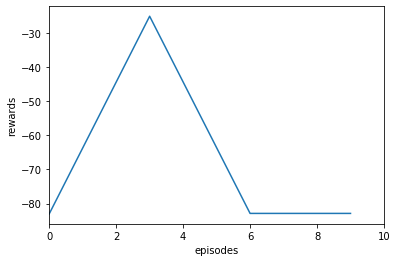

In [10]:
ppoAgent.plot_average_rewards()

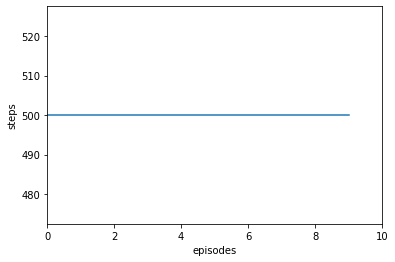

In [11]:
ppoAgent.plot_average_steps()

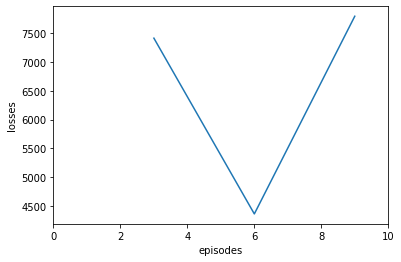

In [12]:
ppoAgent.plot_losses()

## Default training & logging (on custom network)

In [13]:
from easyagents.tfagents import PpoAgent

In [14]:
ppoAgent = PpoAgent( gym_env_name = 'Berater-v1', fc_layers=(500,500,500) )
ppoAgent.train()

I0707 23:04:32.291989  4420 agents.py:92] PpoAgent on Berater-v1 [fc_layers=(500, 500, 500), learning_rate=0.001]
I0707 23:04:32.293987  4420 agents.py:92] TrainingDuration 250=25*10 episodes [max 500 steps/episode, 5 epochs/iteration, policy eval every 50=5*10 episodes]
I0707 23:04:57.007016  4420 agents.py:92] current policy       : avg_reward=-11.471, avg_steps=500.000
I0707 23:05:04.399986  4420 agents.py:92] training    1 of 25  : completed tf_agent.train(...) = 7496.396 [loss]
I0707 23:05:09.174990  4420 agents.py:92] training    2 of 25  : completed tf_agent.train(...) = 4929.996 [loss]
I0707 23:05:14.168985  4420 agents.py:92] training    3 of 25  : completed tf_agent.train(...) = 4983.906 [loss]
I0707 23:05:16.615984  4420 agents.py:92] training    4 of 25  : completed tf_agent.train(...) = 3023.314 [loss]
I0707 23:05:18.992988  4420 agents.py:92] training    5 of 25  : completed tf_agent.train(...) = 1522.000 [loss]
I0707 23:05:43.232025  4420 agents.py:92] current policy    

### Visualize

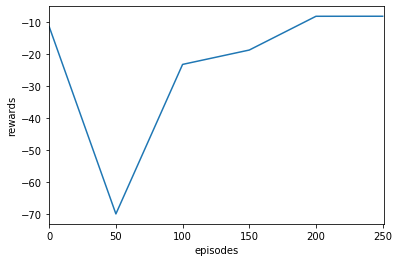

In [15]:
ppoAgent.plot_average_rewards()

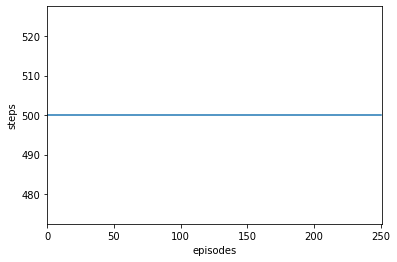

In [16]:
ppoAgent.plot_average_steps()

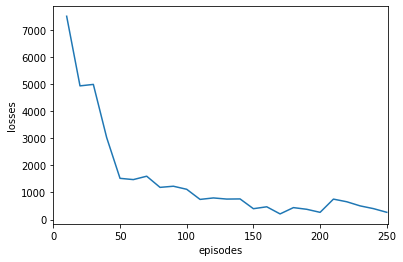

In [17]:
ppoAgent.plot_losses()

## Custom training (duration, learning rate)

In [20]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDuration

In [19]:
training_duration=TrainingDuration( num_iterations = 1500,
                                    num_episodes_per_iteration = 10,
                                    max_steps_per_episode = 200,
                                    num_epochs_per_iteration = 5 )

In [20]:
ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',
                        fc_layers=(500,500,500), 
                        training_duration=training_duration,
                        learning_rate=1e-4
                   )
ppoAgent.train()

### Visualize (with custom y-limits)

In [34]:
ppoAgent.plot_average_rewards(ylim=[-2,1])

In [36]:
ppoAgent.plot_average_steps(ylim=[0,210])

In [38]:
ppoAgent.plot_losses(ylim=[0,500])

In [ ]:
ppoAgent.render_episodes()
